In [ ]:
1.数据少，数据和预训练模型相似
2.数据少，数据和预训练模型不相似
3.数据多，数据和预训练模型相似

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

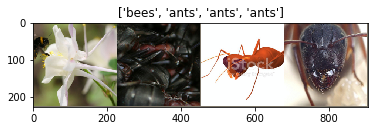

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
import ssl  
ssl._create_default_https_context = ssl._create_unverified_context  

In [12]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

In [15]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_model(model_ft, criterion, optimizer,exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6490 Acc: 0.6393
val Loss: 0.2279 Acc: 0.9150
Epoch 1/9
----------
train Loss: 0.5982 Acc: 0.7295
val Loss: 0.2113 Acc: 0.9150
Epoch 2/9
----------
train Loss: 0.4250 Acc: 0.7910
val Loss: 0.2319 Acc: 0.9216
Epoch 3/9
----------
train Loss: 0.4340 Acc: 0.8033
val Loss: 0.2243 Acc: 0.9216
Epoch 4/9
----------
train Loss: 0.4470 Acc: 0.8033
val Loss: 0.1728 Acc: 0.9412
Epoch 5/9
----------
train Loss: 0.4004 Acc: 0.8115
val Loss: 0.1732 Acc: 0.9346
Epoch 6/9
----------
train Loss: 0.4236 Acc: 0.7787
val Loss: 0.2046 Acc: 0.9216
Epoch 7/9
----------
train Loss: 0.3254 Acc: 0.8402
val Loss: 0.1597 Acc: 0.9477
Epoch 8/9
----------
train Loss: 0.4374 Acc: 0.7951
val Loss: 0.2219 Acc: 0.9281
Epoch 9/9
----------
train Loss: 0.3725 Acc: 0.8238
val Loss: 0.2114 Acc: 0.9281
Training complete in 7m 17s
Best val Acc: 0.947712


In [16]:
model_ft = models.resnet18(pretrained=False)
model_ft.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_model(model_ft, criterion, optimizer,exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7269 Acc: 0.5820
val Loss: 0.6978 Acc: 0.5686
Epoch 1/9
----------
train Loss: 0.8363 Acc: 0.5451
val Loss: 0.6472 Acc: 0.6209
Epoch 2/9
----------
train Loss: 0.8369 Acc: 0.5984
val Loss: 0.6233 Acc: 0.6863
Epoch 3/9
----------
train Loss: 0.8465 Acc: 0.5656
val Loss: 0.6886 Acc: 0.6928
Epoch 4/9
----------
train Loss: 0.8218 Acc: 0.5656
val Loss: 0.7007 Acc: 0.6536
Epoch 5/9
----------
train Loss: 0.5814 Acc: 0.7131
val Loss: 0.6452 Acc: 0.6928
Epoch 6/9
----------
train Loss: 0.5517 Acc: 0.7172
val Loss: 0.6226 Acc: 0.7059
Epoch 7/9
----------
train Loss: 0.6011 Acc: 0.6680
val Loss: 0.7169 Acc: 0.6863
Epoch 8/9
----------
train Loss: 0.5714 Acc: 0.7213
val Loss: 0.6409 Acc: 0.6863
Epoch 9/9
----------
train Loss: 0.6026 Acc: 0.6885
val Loss: 0.6791 Acc: 0.6667
Training complete in 14m 56s
Best val Acc: 0.705882
